In [1]:
import numpy as np
from sklearn.linear_model import LassoLarsIC, LogisticRegression, LogisticRegressionCV
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, Normalizer
import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")

In [2]:
df_x = pd.read_csv('prostate_x.txt', sep=' ')
df_y = pd.read_csv('prostate_y.txt', sep=' ')

elasticnet
l1
l2


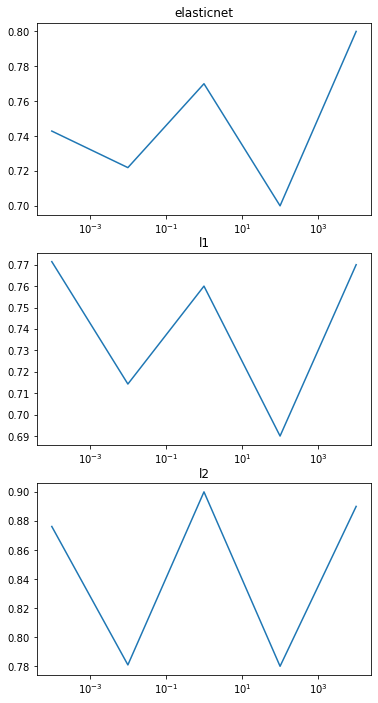

In [3]:
penalties = {'l1', 'l2', 'elasticnet'}
X_transformed = MinMaxScaler().fit_transform(df_x.values)
fig, axs = plt.subplots(nrows=3, figsize=(6,12))
for i, penalty in enumerate(penalties):
    print(penalty)
    lr = LogisticRegressionCV(Cs=5, cv=5, 
                         solver='liblinear' if penalty != 'elasticnet' else 'saga',
                         l1_ratios=None if penalty != 'elasticnet' else [0.5]*5, 
                         max_iter=200,
                         penalty=penalty).fit(X_transformed, df_y.values.flatten())
    if penalty != 'elasticnet':
        axs[i].plot(lr.Cs_, lr.scores_[1].mean(axis=-1))
    else: 
        axs[i].plot(lr.Cs_, lr.scores_[1].mean(axis=-1).mean(axis=-1))

    axs[i].set_title(penalty)
    axs[i].set_xscale('log')

In [4]:
>>> 
>>> norm.cdf(np.array([1,1,1,1,0,0,0,2,2,2]))

array([0.84134475, 0.84134475, 0.84134475, 0.84134475, 0.5       ,
       0.5       , 0.5       , 0.97724987, 0.97724987, 0.97724987])

In [5]:
def PSR(true_b, pred_b):
    true_b = {i for i, b in enumerate(true_b.flatten()) if b != 0}
    pred_b = {i for i, b in enumerate(pred_b.flatten())  if b != 0}
    return len(true_b & pred_b)/len(true_b)  if true_b else 0 
    
def FDR(true_b, pred_b):
    true_b = {i for i, b in enumerate(true_b.flatten())  if b != 0}
    pred_b = {i for i, b in enumerate(pred_b.flatten())  if b != 0}
    return len(pred_b.difference(true_b))/len(pred_b) if pred_b else 0 



def generate_and_fit(n_samples, n_rel_variables, n_irrel_variables, p_func='sigmoid'): 
    B = np.array([1.0]*(n_rel_variables) + [0.0]*(n_irrel_variables)).reshape(1, n_rel_variables+n_irrel_variables)
    X = np.random.normal(0, 1, size=(n_samples,n_rel_variables+n_irrel_variables))

    if p_func == 'sigmoid':
        p = 1.0/(1.0 + np.exp(-B@X.T)).flatten()
    elif p_func == 'norm_cdf':
        p = norm.cdf(B@X.T).flatten()
    y = np.random.binomial(n=1, p=p)
    
    X = np.concatenate([X, np.ones(shape=(n_samples,1))], axis=1) # I add interecpt to data...
    model = LogisticRegressionCV(penalty='l1', cv=10, fit_intercept=False, solver='liblinear', max_iter=1000).fit(X, y) # ...so I skip intercept here
    return model, B
model, B = generate_and_fit(100, 10, 10)


### best lambda : 

In [6]:
1/model.Cs_[model.scores_[1].mean(-1).argmax()]

2.782559402207126

In [7]:
print('PSR')
print(PSR(model.coef_[:,:10], B))
print('FDR')
print(FDR(model.coef_[:,:10], B))

PSR
1.0
FDR
0.0


In [8]:
L = 100
psrs = []
fdrs = []
for _ in range(L):
    model, B = generate_and_fit(100, 10, 10)
    psrs.append(PSR(model.coef_[:,:20], B))
    fdrs.append(FDR(model.coef_[:,:20], B))
print('PSR')
print(np.mean(psrs))
print('FDR')
print(np.mean(fdrs))


PSR
0.6164871745042023
FDR
0.016


50
100
300
500
1000
2000


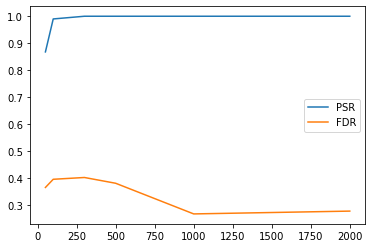

In [9]:
L = 100

n_sample = [50, 100, 300, 500, 1000, 2000]
psrs = []
fdrs = []
n_variables = 20
for sample_size in n_sample:
    print(sample_size)
    psrs_tmp = []
    fdrs_tmp = []
    for _ in range(L):
        model, B = generate_and_fit(sample_size, n_variables// 2, n_variables// 2)
        psrs_tmp.append(PSR(B, model.coef_[:,:n_variables]))
        fdrs_tmp.append(FDR(B, model.coef_[:,:n_variables]))
    
    psrs.append(np.mean(psrs_tmp))
    fdrs.append(np.mean(fdrs_tmp))
    
plt.plot(n_sample, psrs, label='PSR')
plt.plot(n_sample, fdrs, label='FDR')
plt.legend()

10
50
100
200
500


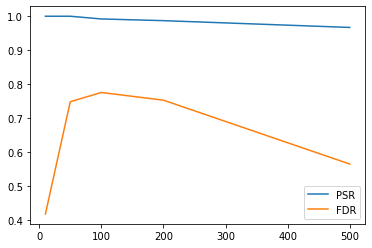

In [10]:
L = 100

psrs = []
fdrs = []
sample_size = 300
n_irr_variables = [10, 50, 100, 200, 500] 
for n_irr_variable in n_irr_variables:
    print(n_irr_variable)
    psrs_tmp = []
    fdrs_tmp = []
    for _ in range(L):
        model, B = generate_and_fit(sample_size, 10, n_irr_variable)
        psrs_tmp.append(PSR(B, model.coef_[:,:10+n_irr_variable]))
        fdrs_tmp.append(FDR(B, model.coef_[:,:10+n_irr_variable]))
    
    psrs.append(np.mean(psrs_tmp))
    fdrs.append(np.mean(fdrs_tmp))
    
plt.plot(n_irr_variables, psrs, label='PSR')
plt.plot(n_irr_variables, fdrs, label='FDR')
plt.legend()

#### change of functions

50
100
300
500
1000
2000


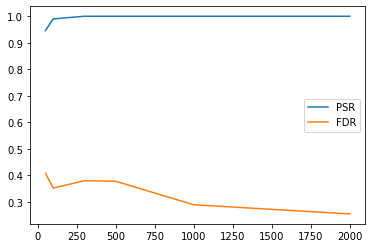

In [11]:
L = 100

n_sample = [50, 100, 300, 500, 1000, 2000]
psrs = []
fdrs = []
n_variables = 20
for sample_size in n_sample:
    print(sample_size)
    psrs_tmp = []
    fdrs_tmp = []
    for _ in range(L):
        model, B = generate_and_fit(sample_size, n_variables// 2, n_variables// 2, p_func='norm_cdf')
        psrs_tmp.append(PSR(B, model.coef_[:,:n_variables]))
        fdrs_tmp.append(FDR(B, model.coef_[:,:n_variables]))
    
    psrs.append(np.mean(psrs_tmp))
    fdrs.append(np.mean(fdrs_tmp))
    
plt.plot(n_sample, psrs, label='PSR')
plt.plot(n_sample, fdrs, label='FDR')
plt.legend()

10
50
100
200
500


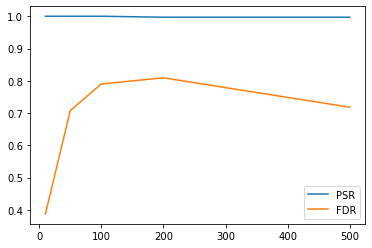

In [12]:
L = 100

psrs = []
fdrs = []
sample_size = 300
n_irr_variables = [10, 50, 100, 200, 500] 
for n_irr_variable in n_irr_variables:
    print(n_irr_variable)
    psrs_tmp = []
    fdrs_tmp = []
    for _ in range(L):
        model, B = generate_and_fit(sample_size, 10, n_irr_variable, p_func='norm_cdf')
        psrs_tmp.append(PSR(B, model.coef_[:,:10+n_irr_variable]))
        fdrs_tmp.append(FDR(B, model.coef_[:,:10+n_irr_variable]))
    
    psrs.append(np.mean(psrs_tmp))
    fdrs.append(np.mean(fdrs_tmp))
    
plt.plot(n_irr_variables, psrs, label='PSR')
plt.plot(n_irr_variables, fdrs, label='FDR')
plt.legend()